# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [1]:
!nvidia-smi

Sat May 25 00:34:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [2]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
# !wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
!pip install gdown --upgrade
!gdown --id '1UdvArRvC7CmRBytmSrG4b3uioPrz1hTd' --output data.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1UdvArRvC7CmRBytmSrG4b3uioPrz1hTd
From (redirected): https://drive.google.com/uc?id=1UdvArRvC7CmRBytmSrG4b3uioPrz1hTd&confirm=t&uuid=73ff8a7e-21c2-4ec6-b824-0daf6434703d
To: /content/data.zip
100% 1.16G/1.16G [00:20<00:00, 57.6MB/s]


In [3]:
# ! unzip food11.zip
! unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/8_5672.jpg        
  inflating: train/8_5678.jpg        
  inflating: train/8_568.jpg         
  inflating: train/8_5704.jpg        
  inflating: train/8_5719.jpg        
  inflating: train/8_572.jpg         
  inflating: train/8_5723.jpg        
  inflating: train/8_5754.jpg        
  inflating: train/8_5768.jpg        
  inflating: train/8_5793.jpg        
  inflating: train/8_5801.jpg        
  inflating: train/8_5803.jpg        
  inflating: train/8_5822.jpg        
  inflating: train/8_5825.jpg        
  inflating: train/8_583.jpg         
  inflating: train/8_5837.jpg        
  inflating: train/8_5851.jpg        
  inflating: train/8_5856.jpg        
  inflating: train/8_5857.jpg        
  inflating: train/8_5924.jpg        
  inflating: train/8_593.jpg         
  inflating: train/8_5938.jpg        
  inflating: train/8_5979.jpg        
  inflating: train/8_5994.jpg        
  inflating: train/8_6002.jpg        

# Import Packages

In [4]:
# Define your log filename
_exp_name = "sample"

In [5]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# Pretrained model
from torchvision.models import resnet18, resnet50, vgg16, densenet121, alexnet, squeezenet1_0, efficientnet
# This is for the progress bar.
from tqdm.auto import tqdm
import random
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
# K-fold cross validation and boosting
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier

In [6]:
myseed = 3407  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [7]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    # transforms.Resize((128, 128)),
    # You may add some transforms here.
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),

    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.55807906, 0.45261728, 0.34557677], std=[0.23075283, 0.24137004, 0.24039967])
])

# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.Resize(256),  # 256
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.55807906, 0.45261728, 0.34557677], std=[0.23075283, 0.24137004, 0.24039967])
])

# Q1. Augmentation Implementation Visualization

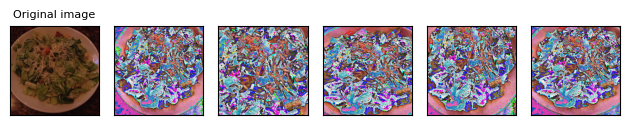

In [8]:
# I want to show you an example code of Q1. Augmentation Implementation that visualizes the effects of different image transformations.
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'

# You can change the file path to match your image
orig_img = Image.open('train/8_5672.jpg')


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Create a list of five transformed images from the original image using the train_tfm function
demo = [train_tfm(orig_img) for i in range(5)]

# Convert the transformed images from tensors to PIL images
pil_img_demo = [Image.fromarray(np.moveaxis(img.numpy()*255, 0, -1).astype(np.uint8)) for img in demo]

# Plot the transformed images using the plot function
plot(pil_img_demo)


### **可视化部分代码的注释版**

In [ ]:
import matplotlib.pyplot as plt

# 设置保存图像时边框的类型为紧凑型
plt.rcParams["savefig.bbox"] = 'tight'

# 你可以更改文件路径以匹配你的图像
orig_img = Image.open('train/8_5672.jpg')

# 定义一个函数来绘制图像和它的变换
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # 即使只有一行也创建一个2D网格
        imgs = [imgs]

    num_rows = len(imgs)  # 网格的行数
    num_cols = len(imgs[0]) + with_orig  # 网格的列数，根据是否显示原始图像决定
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)  # 创建子图网格
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row  # 如果需要，则在每行前添加原始图像
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]  # 获取当前的子图
            ax.imshow(np.asarray(img), **imshow_kwargs)  # 显示图像
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])  # 移除坐标轴标签和刻度

    if with_orig:
        axs[0, 0].set(title='Original image')  # 设置第一张图的标题为“原始图像”
        axs[0, 0].title.set_size(8)  # 设置标题大小
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])  # 设置每行的标题

    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

# 创建一个列表，包含从原始图像使用train_tfm函数转换得到的五个图像
demo = [train_tfm(orig_img) for i in range(5)]

# 将转换后的图像从张量转换为PIL图像
pil_img_demo = [Image.fromarray(np.moveaxis(img.numpy()*255, 0, -1).astype(np.uint8)) for img in demo]

# 使用plot函数绘制转换后的图像
plot(pil_img_demo)


# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [23]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files

        self.transform = tfm
        print('Num of element: ', len(self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)

        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label

        return im,label


class MySubset(Subset):
    def __init__(self, dataset, indices, tfm=test_tfm):
        super().__init__(dataset, indices)
        self.transform = tfm

    def __getitem__(self, idx):
        if isinstance(idx, list):
            return self.dataset[[self.indices[i] for i in idx]]
        self.dataset.transform = self.transform
        return self.dataset[self.indices[idx]]
        # do something with self.dataset[self.indices[idx]]
        # return a modified item

# Model

In [10]:
# Pretrained model
from torchvision.models import resnet18

In [11]:
model = resnet18(pretrained=False, progress=False, num_classes=11)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Configurations

In [12]:
# "cuda" only when GPUs are available.
# If you use apple chip (mac), you can change "cpu" to "mps"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.

model = model.to(device)

Resume = False
if Resume:
    model.load_state_dict(torch.load(f"{_exp_name}_best.ckpt", map_location='cuda'))

# The number of batch size.
batch_size = 64

# The number of training epochs.
n_epochs = 200

# If no improvement in 'patience' epochs, early stop.
patience = n_epochs // 8
k_fold = 4

# For the classification task, we use cross-entropy as the measurement of performance.
# criterion = nn.CrossEntropyLoss()
# Label Smoothing Cross Entropy Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5) # 3e-4

# Create a learning rate scheduler that reduces the learning rate when the metric stops improving
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=patience/2, threshold=0.05)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=16, T_mult=1)

# Dataloader

In [13]:
# # Construct train and valid datasets.
# # The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

## Normalization

In [14]:
'''
def get_mean_std(loader):
  # VAR[X] = E[X**2] - E[X]**2
  channel_sum, channel_squared_sum, num_batches = 0, 0, 0
  for data, _ in loader:
    channel_sum += torch.mean(data, dim=[0, 2, 3])
    channel_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
    num_batches += 1
  mean = channel_sum / num_batches
  std = channel_squared_sum / num_batches - mean**2
  return mean, std

mean, std = get_mean_std(train_loader)
print(mean)
print(std)
'''

'\ndef get_mean_std(loader):\n  # VAR[X] = E[X**2] - E[X]**2\n  channel_sum, channel_squared_sum, num_batches = 0, 0, 0\n  for data, _ in loader:\n    channel_sum += torch.mean(data, dim=[0, 2, 3])\n    channel_squared_sum += torch.mean(data**2, dim=[0, 2, 3])\n    num_batches += 1\n  mean = channel_sum / num_batches\n  std = channel_squared_sum / num_batches - mean**2\n  return mean, std\n\nmean, std = get_mean_std(train_loader)\nprint(mean)\nprint(std)\n'

# Start Training

## Cross validation
You can implement cross validation entirely using the cross_val_score in sklearn.model_selection, but I'll show you another way to implement it here.

In [15]:
import os
import shutil

# Check if the merge folder exists, if not, create it
merge_dir = "merge"
if not os.path.isdir(merge_dir):
    os.mkdir(merge_dir)

    #  Get all the file names in the train and valid folders
    train_files = os.listdir("train")
    valid_files = os.listdir("valid")

    # Copy all the files in the train and valid folders to the merge folder
    for file in train_files:
        shutil.copy(os.path.join("train", file), merge_dir)
    for file in valid_files:
        shutil.copy(os.path.join("valid", file), merge_dir)

In [16]:
total_files = train_files + valid_files
random.shuffle(total_files)
num = len(total_files) // k_fold

In [17]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# The number of training epochs and patience.


test_fold = k_fold

for i in range(test_fold):
    fold = i+1
    print(f'\n\nStarting Fold: {fold} ********************************************')
    # model = Classifier(Residual_Block, num_layers).to(device)
    # criterion = FocalLoss(11, alpha=alpha)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=2e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=16, T_mult=1)
    stale = 0
    best_acc = 0

    val_data = total_files[i*num: (i+1)*num]
    train_data = total_files[:i*num] + total_files[(i+1)*num:]

    # train_set = FoodDataset(tfm=train_tfm, files=train_data)
    #train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    # valid_set = FoodDataset(tfm=test_tfm, files=val_data)
    # valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    for epoch in range(n_epochs):

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []
        lr = optimizer.param_groups[0]["lr"]

        pbar = tqdm(train_loader)
        pbar.set_description(f'T: {epoch+1:03d}/{n_epochs:03d}')
        for batch in pbar:

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()
            #print(imgs.shape,labels.shape)

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)
            pbar.set_postfix({'lr':lr, 'b_loss':loss.item(), 'b_acc':acc.item(),
                    'loss':sum(train_loss)/len(train_loss), 'acc': sum(train_accs).item()/len(train_accs)})

        scheduler.step()


        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        pbar = tqdm(valid_loader)
        pbar.set_description(f'V: {epoch+1:03d}/{n_epochs:03d}')
        for batch in pbar:

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)
            pbar.set_postfix({'v_loss':sum(valid_loss)/len(valid_loss),
                              'v_acc': sum(valid_accs).item()/len(valid_accs)})

            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)


        if valid_acc > best_acc:
            print(f"Best model found at fold {fold} epoch {epoch+1}, acc={valid_acc:.5f}, saving model")
            torch.save(model.state_dict(), f"Fold_{fold}_best.ckpt")
            # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f"No improvment {patience} consecutive epochs, early stopping")
                break

cuda


Starting Fold: 1 ********************************************


  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 1, acc=0.37277, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 2, acc=0.40838, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 3, acc=0.45215, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 4, acc=0.46051, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 5, acc=0.49238, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 6, acc=0.51532, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 7, acc=0.57910, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 8, acc=0.58958, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 9, acc=0.62851, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 10, acc=0.63975, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 11, acc=0.67772, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 13, acc=0.70897, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 14, acc=0.72130, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 16, acc=0.72201, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 25, acc=0.73487, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 26, acc=0.74213, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 27, acc=0.75516, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 29, acc=0.76882, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 30, acc=0.77807, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 31, acc=0.78406, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 32, acc=0.79290, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 45, acc=0.80564, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 46, acc=0.80729, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 47, acc=0.81492, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 61, acc=0.81725, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 62, acc=0.82264, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 63, acc=0.82632, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 64, acc=0.82693, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 77, acc=0.82739, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 80, acc=0.82762, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 94, acc=0.83205, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 96, acc=0.83335, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 109, acc=0.83520, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 110, acc=0.83915, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 111, acc=0.84306, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 127, acc=0.84402, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 140, acc=0.84658, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 1 epoch 144, acc=0.84907, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

No improvment 25 consecutive epochs, early stopping


Starting Fold: 2 ********************************************


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 1, acc=0.78673, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 2, acc=0.80252, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 3, acc=0.80898, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 6, acc=0.81085, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 7, acc=0.81409, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 8, acc=0.83251, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 9, acc=0.83470, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 10, acc=0.83758, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 11, acc=0.83968, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 12, acc=0.84713, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 14, acc=0.85005, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 2 epoch 15, acc=0.85291, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

No improvment 25 consecutive epochs, early stopping


Starting Fold: 3 ********************************************


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 1, acc=0.80393, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 2, acc=0.81553, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 3, acc=0.82440, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 5, acc=0.82483, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 6, acc=0.83447, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 8, acc=0.83552, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 9, acc=0.83616, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 10, acc=0.84480, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 11, acc=0.84633, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 12, acc=0.84653, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 13, acc=0.85334, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 14, acc=0.85567, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 3 epoch 15, acc=0.85727, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

No improvment 25 consecutive epochs, early stopping


Starting Fold: 4 ********************************************


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 1, acc=0.82522, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 5, acc=0.83006, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 6, acc=0.83162, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 7, acc=0.83918, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 9, acc=0.84439, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 10, acc=0.85051, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 13, acc=0.85213, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 14, acc=0.85256, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 16, acc=0.85373, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 27, acc=0.85391, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 29, acc=0.85423, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 30, acc=0.85750, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Best model found at fold 4 epoch 31, acc=0.85814, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

No improvment 25 consecutive epochs, early stopping


# Testing

## Test Loader

In [24]:
test_dir = "./test"
test_set = FoodDataset(test_dir, tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

Num of element:  3000


In [20]:
test_dir = "./test"
# test_tfms = [test_tfm1, test_tfm2, test_tfm3, test_tfm4, test_tfm5]
test_loaders = []
for i in range(5):
    test_set_i = FoodDataset(test_dir, tfm=train_tfm)
    test_loader_i = DataLoader(test_set_i, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loaders.append(test_loader_i)

## TTA

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

models = []
for i in range(0, 4):
    fold = i + 1
    model_best = model.to(device)
    model_best.load_state_dict(torch.load(f"Fold_{fold}_best.ckpt"))
    model_best.eval()
    models.append(model_best)

preds = [[], [], [], [], [], []]
with torch.no_grad():
    for data, _ in test_loader:
        batch_preds = []
        for model_best in models:
            batch_preds.append(model_best(data.to(device)).cpu().data.numpy())
        batch_preds = sum(batch_preds)
        preds[0].extend(batch_preds.squeeze().tolist())

        #batch_label = np.argmax(batch_preds, axis=1)
        #prediction += batch_label.squeeze().tolist()

    for i, loader in enumerate(test_loaders):
        for data, _ in loader:
            batch_preds = []
            for model_best in models:
                batch_preds.append(model_best(data.to(device)).cpu().data.numpy())
            batch_preds = sum(batch_preds)
            preds[i+1].extend(batch_preds.squeeze().tolist())

preds = np.array(preds)
print(preds.shape)
preds = 0.6* preds[0] + 0.1 * preds[1] + 0.1 * preds[2] + 0.1 * preds[3] + 0.1 * preds[4] + 0.1 * preds[5]
print(preds.shape)
prediction = np.argmax(preds, axis=1)

cuda
(6, 3000, 11)
(3000, 11)


In [25]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("resnet18.csv",index = False)

# Tensorboard

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./runs/

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice.
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You can add some transforms here.
    transforms.ToTensor(),
])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images).


In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = Classifier().to(device)
state_dict = torch.load(f"models/{_exp_name}_Classifier_fold1_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model)

In [ ]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 19 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

# Dataloader for test